In [1]:
import numpy as np
import tnn
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as f

from datasets import load_dataset
from torch.utils.data import DataLoader

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [2]:
dataset = load_dataset("ylecun/mnist", num_proc=2)
train_size = 10000
test_size = 1000

train = dataset.get("train")
test = dataset.get("test")

train_indices = np.random.choice(len(train), size=train_size, replace=False)
test_indices = np.random.choice(len(test), size=test_size, replace=False)

train = train.select(train_indices)
test = test.select(test_indices)

In [3]:
def to_numpy(example):
    arr = np.reshape(example["image"], -1) / 255.0
    example["input"] = arr
    return example


train_dataset = train.map(to_numpy, num_proc=2).select_columns(["input", "label"])
test_dataset = test.map(to_numpy, num_proc=2).select_columns(["input", "label"])

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def collate_fn(batch):
    inputs = torch.tensor([ex["input"] for ex in batch]).float()
    labels = torch.tensor([ex["label"] for ex in batch]).long()
    return inputs, labels


trainloader = data.DataLoader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=2,
)
testloader = data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=2,
)

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(28 * 28, 512)
        self.norm_1 = nn.LayerNorm(512)
        self.drop_1 = nn.Dropout(0.4)
        self.linear_2 = nn.Linear(512, 512)
        self.norm_2 = nn.LayerNorm(512)
        self.drop_2 = nn.Dropout(0.2)
        self.linear_3 = nn.Linear(512, 512)
        self.norm_3 = nn.LayerNorm(512)
        self.linear_4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.norm_1(self.linear_1(x))
        x = self.drop_1(f.relu(x))

        x = self.norm_2(self.linear_2(x))
        x = self.drop_2(f.relu(x))

        x = self.norm_3(self.linear_3(x))
        x = self.linear_4(f.relu(x))
        return {"logits": x}

## Batch Gradient Descent

In [6]:
lr = 1e-1
model = tnn.Model(MLP())
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [7]:
trainer = tnn.Trainer(
    model,
    optim,
    loss_fn,
    trainloader,
    testloader,
    save_weights=False,
    device=device,
    path="./batch.h5",
    verbose=10,
)

In [8]:
batch_metrics = trainer.train(epochs=50)

model using cuda
training started
(epoch: 10): (train loss: 1.5518, test loss: 1.4896, train acc: 0.4897, test acc: 0.5660)
(epoch: 20): (train loss: 0.8032, test loss: 0.6930, train acc: 0.7391, test acc: 0.7680)
(epoch: 30): (train loss: 0.5772, test loss: 0.4378, train acc: 0.8168, test acc: 0.8640)
(epoch: 40): (train loss: 0.4571, test loss: 0.2938, train acc: 0.8603, test acc: 0.9150)
(epoch: 50): (train loss: 0.4071, test loss: 0.2759, train acc: 0.8690, test acc: 0.9220)
training complete
train_losses saved to ./batch.h5/metrics/train_losses
test_losses saved to ./batch.h5/metrics/test_losses
train_accs saved to ./batch.h5/metrics/train_accs
test_accs saved to ./batch.h5/metrics/test_accs


## Mini-batch Gradient Descent

In [9]:
trainloader = data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=2,
)

In [10]:
model = tnn.Model(MLP())
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
trainer = tnn.Trainer(
    model,
    optim,
    loss_fn,
    trainloader,
    testloader,
    save_weights=False,
    device=device,
    path="./mini-batch.h5",
    verbose=10,
)

In [12]:
mini_batch_metrics = trainer.train(epochs=50)

model using cuda
training started
(epoch: 10): (train loss: 0.0954, test loss: 0.1259, train acc: 0.9705, test acc: 0.9690)
(epoch: 20): (train loss: 0.0688, test loss: 0.3100, train acc: 0.9774, test acc: 0.9290)
(epoch: 30): (train loss: 0.0224, test loss: 0.1685, train acc: 0.9924, test acc: 0.9620)
(epoch: 40): (train loss: 0.0192, test loss: 0.1335, train acc: 0.9939, test acc: 0.9690)
(epoch: 50): (train loss: 0.0167, test loss: 0.3884, train acc: 0.9953, test acc: 0.9170)
training complete
train_losses saved to ./mini-batch.h5/metrics/train_losses
test_losses saved to ./mini-batch.h5/metrics/test_losses
train_accs saved to ./mini-batch.h5/metrics/train_accs
test_accs saved to ./mini-batch.h5/metrics/test_accs


## Stochastic Gradient Descent

In [13]:
inputs = torch.tensor([ex["input"] for ex in train_dataset]).float().to(device)
labels = torch.tensor([ex["label"] for ex in train_dataset]).long().to(device)
train_tensor_dataset = data.TensorDataset(inputs, labels)

trainloader = data.DataLoader(
    train_tensor_dataset, batch_size=1, shuffle=True, drop_last=False
)

In [14]:
model = tnn.Model(MLP())
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
trainer = tnn.Trainer(
    model,
    optim,
    loss_fn,
    trainloader,
    testloader,
    save_weights=False,
    device=device,
    path="./sgd.h5",
    verbose=10,
)

In [16]:
sgd_metrics = trainer.train(epochs=50)

model using cuda
training started
(epoch: 10): (train loss: 0.1518, test loss: 0.1797, train acc: 0.9552, test acc: 0.9590)
(epoch: 20): (train loss: 0.0848, test loss: 0.1737, train acc: 0.9734, test acc: 0.9530)
(epoch: 30): (train loss: 0.0603, test loss: 0.1520, train acc: 0.9828, test acc: 0.9700)
(epoch: 40): (train loss: 0.0430, test loss: 0.1631, train acc: 0.9867, test acc: 0.9650)
(epoch: 50): (train loss: 0.0399, test loss: 0.1379, train acc: 0.9889, test acc: 0.9740)
training complete
train_losses saved to ./sgd.h5/metrics/train_losses
test_losses saved to ./sgd.h5/metrics/test_losses
train_accs saved to ./sgd.h5/metrics/train_accs
test_accs saved to ./sgd.h5/metrics/test_accs


In [17]:
batch_metric_losses = {
    "train loss": batch_metrics.get("train_losses"),
    "test loss": batch_metrics.get("test_losses"),
}
batch_metric_accs = {
    "train acc": batch_metrics.get("train_accs"),
    "test acc": batch_metrics.get("test_accs"),
}

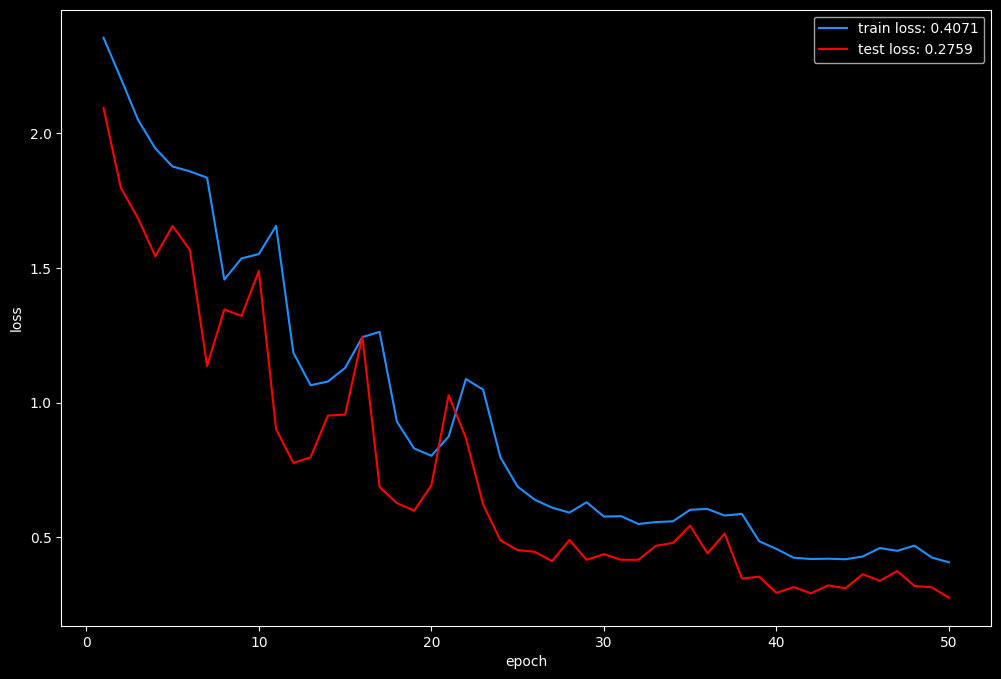

In [18]:
tnn.plot_metrics(batch_metric_losses, path="../images/batch-mnist-loss.png")

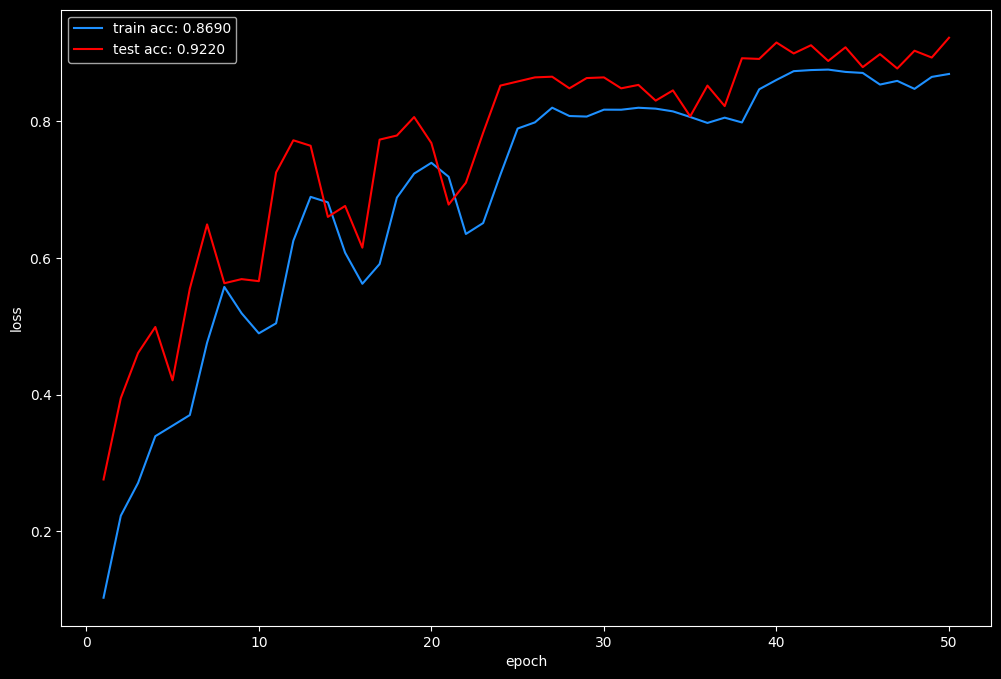

In [19]:
tnn.plot_metrics(batch_metric_accs, path="../images/batch-mnist-acc.png")

In [20]:
mini_batch_metric_losses = {
    "train loss": mini_batch_metrics.get("train_losses"),
    "test loss": mini_batch_metrics.get("test_losses"),
}
mini_batch_metric_accs = {
    "train acc": mini_batch_metrics.get("train_accs"),
    "test acc": mini_batch_metrics.get("test_accs"),
}

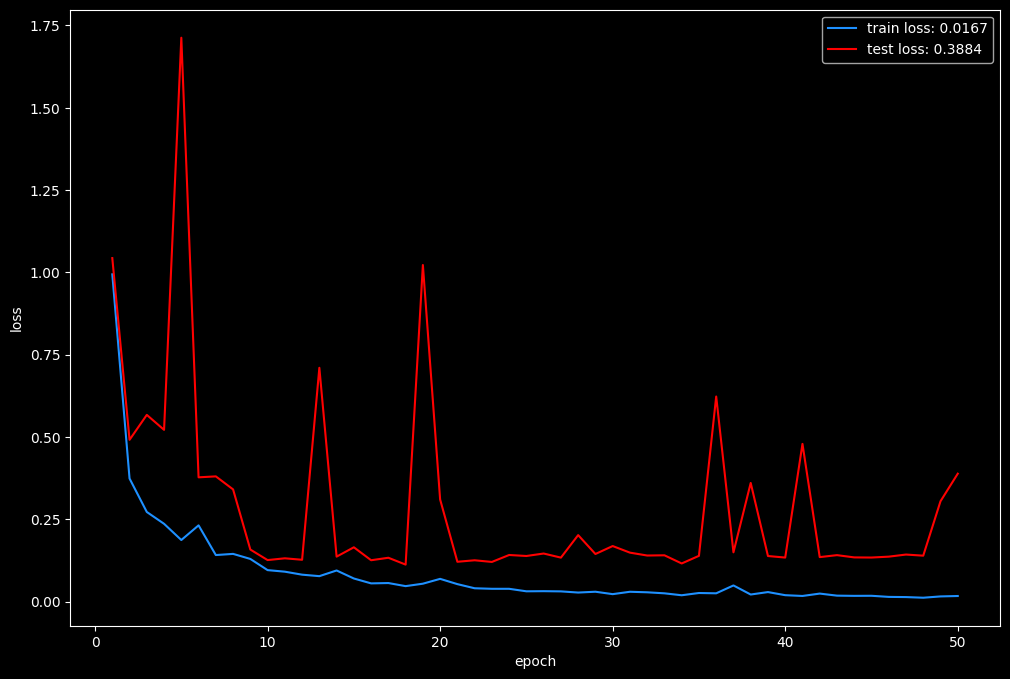

In [21]:
tnn.plot_metrics(mini_batch_metric_losses, path="../images/mini-batch-mnist-loss.png")

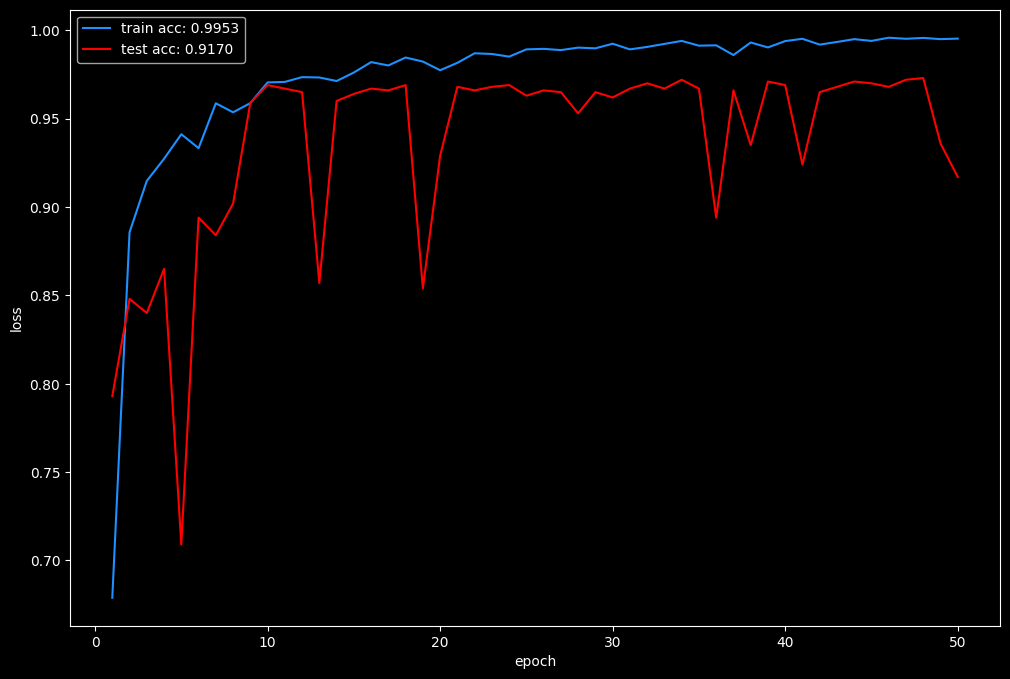

In [22]:
tnn.plot_metrics(mini_batch_metric_accs, path="../images/mini-batch-mnist-acc.png")

In [23]:
sgd_metric_losses = {
    "train loss": sgd_metrics.get("train_losses"),
    "test loss": sgd_metrics.get("test_losses"),
}
sgd_metric_accs = {
    "train acc": sgd_metrics.get("train_accs"),
    "test acc": sgd_metrics.get("test_accs"),
}

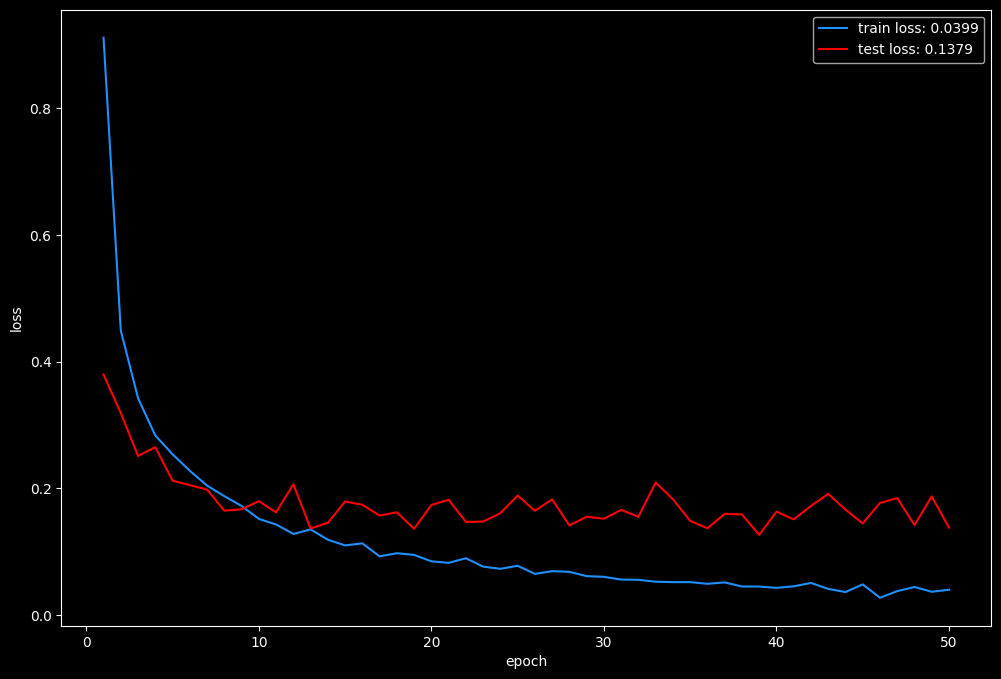

In [24]:
tnn.plot_metrics(sgd_metric_losses, path="../images/sgd-mnist-loss.png")

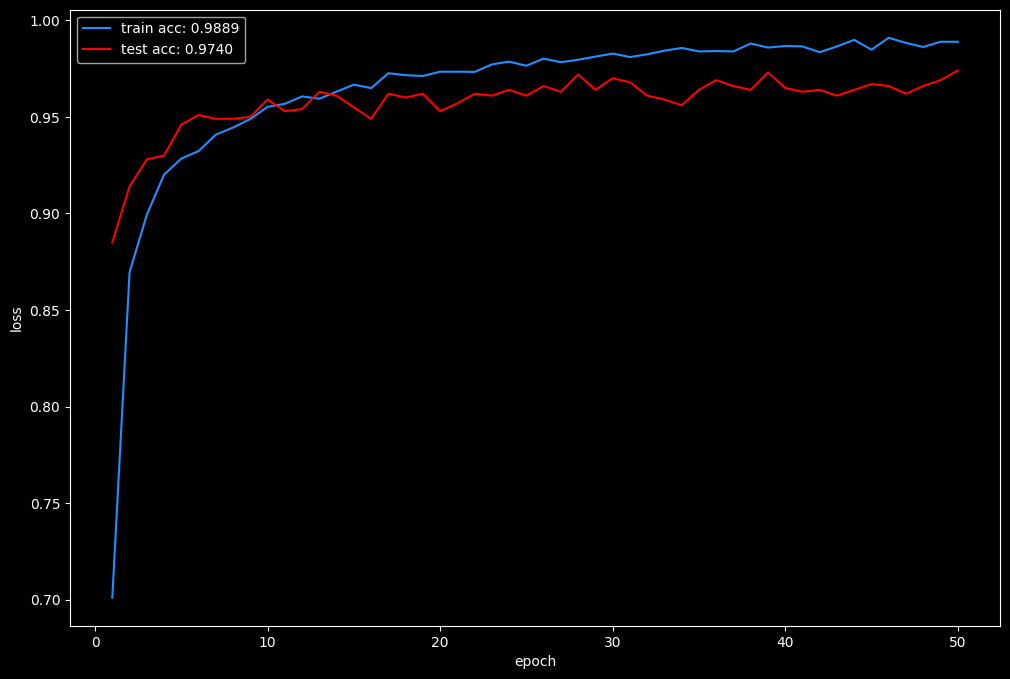

In [25]:
tnn.plot_metrics(sgd_metric_accs, path="../images/sgd-mnist-acc.png")